In [1]:

import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline

import halomod as hm
import hmf

    
    
    


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# My catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  

t3= Table.read(masked)


t=join(t,t3,keys='id') # joined table


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')



#Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)
randoms = t2

config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


In [5]:
import package.subsample

## Line below doesn't properly import my package ?? Perque?

In [3]:
#from package import subsample,correlation_function, subsample_analysis, cosmology


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


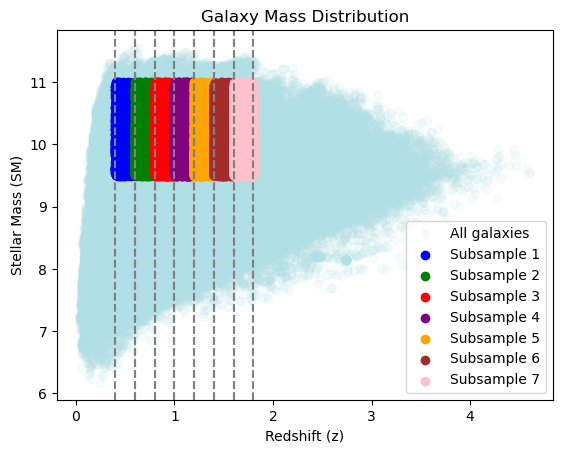

Subsample 1: N = 5410
  z_mean: 0.5
  SM_mean: 10.25
  z_min: 0.4

Subsample 2: N = 8925
  z_mean: 0.7
  SM_mean: 10.25
  z_min: 0.6

Subsample 3: N = 11153
  z_mean: 0.9
  SM_mean: 10.25
  z_min: 0.8

Subsample 4: N = 9890
  z_mean: 1.1
  SM_mean: 10.25
  z_min: 1.0

Subsample 5: N = 10340
  z_mean: 1.2999999999999998
  SM_mean: 10.25
  z_min: 1.2

Subsample 6: N = 7706
  z_mean: 1.5
  SM_mean: 10.25
  z_min: 1.4

Subsample 7: N = 7922
  z_mean: 1.7000000000000002
  SM_mean: 10.25
  z_min: 1.6



In [6]:
    
# Define z and SM ranges
z_values = np.array([ 0.4,0.6,0.8, 1.0, 1.2, 1.4,1.6,1.8])

SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM

#SM_range = np.linspace(8, 11, num=4) # diff Sm



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = package.subsample.Subsample(z_min, z_max, SM_min, SM_max)
        
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',color='powderblue',alpha=0.1)

# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']
num_colors = len(colors)


for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i % num_colors])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()